In [1]:
import nltk
import os
import re
import itertools
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import codecs
from textblob import TextBlob
import pandas as pd
import re
%matplotlib inline
%load_ext autoreload

C:\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
# Open and read transcripts in NLTK
f1=codecs.open('../../../private/brainstorming_viz_data/free_group/teamA_part1_divergent.txt', 'r', encoding='utf-8')
f2=codecs.open('../../../private/brainstorming_viz_data/free_group/teamA_part2_convergent.txt', 'r', encoding='utf-8')
f1Temp = codecs.open('tempASCII', 'w', encoding='ascii', errors='ignore')
f2Temp = codecs.open('tempASCII', 'w', encoding='ascii', errors='ignore')
f1Temp.write('free_group/teamA_part1_divergent_bak.txt')
f2Temp.write('free_group/teamA_part1_convergent_bak.txt')
divergent_raw = f1.read()
convergent_raw = f2.read()
regex = re.compile(".*?\\[(.*?)\\]")

def removeObservations(test_str):
    # removes all text within parantheses
    # these are usually observations by the transcriber
    # and thus should not be considered in content analysis
    # code from http://stackoverflow.com/questions/14596884/remove-text-between-and-in-python
    ret = ''
    skip1c = 0
    skip2c = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    return ret

divergent = removeObservations(divergent_raw)
convergent = removeObservations(convergent_raw)

In [3]:
# Extract Noun phrases using TextBlob
blobDivergent = TextBlob(divergent)
blobConvergent = TextBlob(convergent)
nounDiv = blobDivergent.np_counts
nounConv = blobConvergent.np_counts
dfnp1 = pd.DataFrame(columns=['Noun phrases in Divergent phase', 'Frequencies'])
dfnp2 = pd.DataFrame(columns=['Noun phrases in Convergent phase', 'Frequencies'])
u=1
for i in nounDiv:
    dfnp1.loc[u] = [i, nounDiv[i]]
    u+=1

u=1
for i in nounConv:
    dfnp2.loc[u] = [i, nounConv[i]]
    u+=1
    
print("The total number of noun phrases in the divergent phase:", len(nounDiv))
dfnp1.head(15)

The total number of noun phrases in the divergent phase: 221


,Noun phrases in Divergent phase,Frequencies
1,scuba diver,1
2,strap kids,1
3,pretty good ideas,1
4,time clock,1
5,well,2
6,trying,1
7,gon na,4
8,popgun,1
9,you’ve,1
10,projectile guns,2


In [4]:
print("The total number of noun phrases in the convergent phase:", len(nounConv))
dfnp2.head(15)

The total number of noun phrases in the convergent phase: 103


,Noun phrases in Convergent phase,Frequencies
1,final thing,1
2,like—i don’t,1
3,people’s oars,1
4,yeah,14
5,they’ll,1
6,mine’s,1
7,gon na,4
8,cleaning,1
9,it’s gon na work like—bam,1
10,final concept.”,1


In [5]:
# Common noun phrases in both phases
common = {}
notcommon = {}
dfc = pd.DataFrame(columns=["Common noun phrases", "Divergent", "Convergent"])
u=1
for i in nounDiv:
    if i in nounConv:
        common[i] = min(nounDiv[i], nounConv[i])
        notcommon[i] = (nounDiv[i], nounConv[i])
        dfc.loc[u] = [i, nounDiv[i], nounConv[i]]
        u+=1
dfc

,Common noun phrases,Divergent,Convergent
1,gon na,4,4
2,one’s gon na,1,1
3,it’s,8,2
4,okay,10,2
5,good idea,3,1
6,have,2,2
7,i’ll,1,2
8,mechanical motion,1,1
9,let’s,3,1
10,yeah,55,14


In [6]:
# Noun phrases that can be removed:
to_be_removed = [u'okay', u'yeah']
keys_to_delete = []
for key in common.keys():
    if key in to_be_removed:
        keys_to_delete.append(key)
for key in keys_to_delete:
    del common[key] # could not have deleted item from iterable 
                    # from within the loop
ccommon=common.keys()

In [11]:
# Function to count co-occurrences of common noun phrases in sentences
def occurrences(source, terms):
    ALL_sentences=sent_tokenize(source) # creates a list of sentences
    combinations_terms = list(itertools.combinations(terms,2)) # NC2 of terms
    n = len(combinations_terms)
    occurlist = []
    for i in range(1, n):
        for j in ALL_sentences:
            temp = list(combinations_terms[i])
            # Find every combination of term 1 followed by term 2 in
            # term pair (1,2)
            out=re.compile(str(temp[0]) + '(.*?)' + str(temp[1]), 
                           re.DOTALL | re.IGNORECASE).findall(j)
            if out:
                occurlist.append(str(temp[0]) + ' - ' + str(temp[1]))
            # Find every combination of term 2 followed by term 1 in
            # term pair (1,2)
            out2 = re.compile(str(temp[1]) + '(.*?)' + str(temp[0]),
                             re.DOTALL | re.IGNORECASE).findall(j)
            if out2:
                occurlist.append(str(temp[1]) + ' - ' + str(temp[0]))
    occurdict = {}
    # count occurrences of term pairs
    for i in occurlist:
        if i not in occurdict:
            occurdict[i] = 1
        else : 
            occurdict[i] = occurdict[i] + 1
    return occurdict

# Call function to find divergent and convergent terms
Divdict = occurrences(divergent, ccommon)
Convdict = occurrences(convergent, ccommon)
# nounDivdict = dict(nounDiv)
# nounConvdict = dict(nounConv)
# Divdict = occurrences(divergent, nounDiv)
# Convdict = occurrences(convergent, nounConv)

In [12]:
# Function to construct a graph of common noun phrases tied by 
# their co-occurrences in sentences of a transcript
def makegraph(occurrences):
    G = nx.Graph()
    weights = []
    for edgs,wt in occurrences.items():
        edg = edgs.split(' - ')
        G.add_edge(edg[0], edg[1], weight=wt)
        G.add_node(edg[0], label=edg[0])
        G.add_node(edg[1], label=edg[1])
        weights.append(wt)
    return [G, weights]

DivGraphData = makegraph(Divdict)
ConvGraphData = makegraph(Convdict)
GDiv = DivGraphData[0]
GConv = ConvGraphData[0]
DivEdges = DivGraphData[1]
ConvEdges = ConvGraphData[1]

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


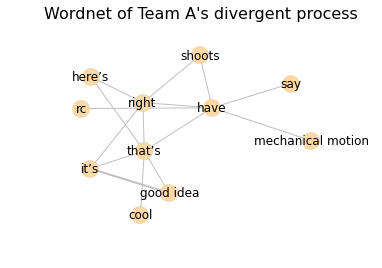

In [13]:
# Plot graph of common phrases in Team A's divergent phase
from networkx.drawing.nx_agraph import graphviz_layout
pos = nx.spring_layout(GDiv, iterations=20)
sstt="Team A's wordnet during divergent phase of brainstorming"
possit = nx.draw_networkx_nodes(GDiv, pos=pos,  
                          node_color='#fed9a6', linewidths=0.05,
                          withLabels='True')
labels = nx.draw_networkx_labels(GDiv, pos=pos)
edges = nx.draw_networkx_edges(GDiv, pos=pos, width=DivEdges,
                               edge_color='#c0c0c0')
font = {'fontname'   : 'Helvetica',
        'color'      : 'k',
        'fontweight' : 'normal',
        'fontsize'   : 16}

plt.axis('off')
plt.title("Wordnet of Team A's divergent process", font)
plt.show()

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


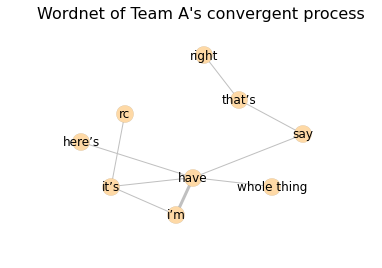

In [14]:
# Plot graph of common phrases in Team A's convergent phase
from networkx.drawing.nx_agraph import graphviz_layout
pos = nx.spring_layout(GConv, iterations=20)
sstt="Team A's wordnet during divergent phase of brainstorming"
possit = nx.draw_networkx_nodes(GConv, pos=pos,  
                          node_color='#fed9a6', linewidths=0.05,
                          withLabels='True')
labels = nx.draw_networkx_labels(GConv, pos=pos)
edges = nx.draw_networkx_edges(GConv, pos=pos, width=ConvEdges,
                               edge_color='#c0c0c0')
plt.axis('off')
plt.title("Wordnet of Team A's convergent process", font)
plt.show()